In [1]:
%matplotlib inline 

import fiona
import shapely
import rasterio
import torch
import pyproj
from rasterio import features
from fiona.transform import transform as f_transform
import numpy as np
from shapely import plotting
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.collections import PatchCollection
from copy import copy
from rasterio import plot as rioplt
from shapely import ops


/d/pfournie/dl_toolbox/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from itertools import product

def get_tiles(nols, nrows, size, size2=None, step=None, step2=None, col_offset=0, row_offset=0, cover_all=True):
    
    if step is None: step = size
    if size2 is None: size2 = size
    if step2 is None: step2 = step

    max_col_offset = int(np.ceil((nols-size)/step))
    # Remove all offsets such that offset+size > nols and add one offset to
    # reach nols
    col_offsets = list(range(col_offset, col_offset + nols, step))[:max_col_offset+int(cover_all)]
    if cover_all:
        col_offsets[max_col_offset] = col_offset + nols - size

    max_row_offset = int(np.ceil((nrows-size2)/step2))
    # Remove all offsets such that offset+size > nols and add one offset to
    # reach nols
    row_offsets = list(range(row_offset, row_offset + nrows, step2))[:max_row_offset+int(cover_all)]
    if cover_all:
        row_offsets[max_row_offset] = row_offset + nrows - size2

    offsets = product(col_offsets, row_offsets)
    for col_off, row_off in offsets:
        yield rasterio.windows.Window(col_off=col_off, row_off=row_off, width=size, height=size2)

In [3]:
def generate_polygon(bbox):
    """
    Generates a list of coordinates: [[x1,y1],[x2,y2],[x3,y3],[x4,y4],[x1,y1]]
    """
    return [[bbox[0],bbox[1]],
             [bbox[2],bbox[1]],
             [bbox[2],bbox[3]],
             [bbox[0],bbox[3]],
             [bbox[0],bbox[1]]]

In [4]:
def shape_color(name, alpha):
    color = colors.to_rgba(name)
    facecolor = list(color)
    facecolor[-1] = alpha
    facecolor = tuple(facecolor)
    edgecolor = color
    return facecolor, edgecolor

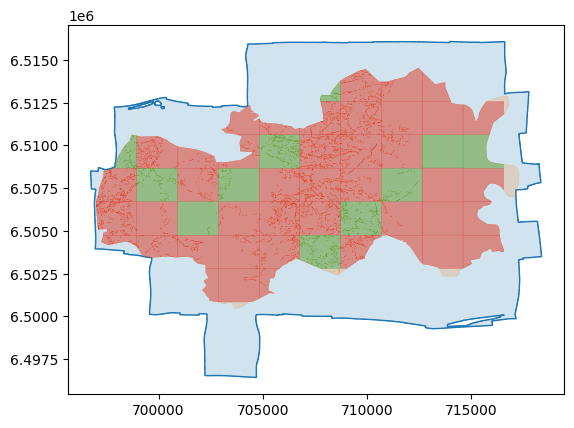

In [5]:
img_path_46 = '/data/alumhi/1946-3.tif'
label_path_46 = '/data/alumhi/1946-labels.tif'
shapes_path_46 = '/data/alumhi/OCS_1946_210714_VERSION_FINALE_Merge.shp'

img46 = rasterio.open(img_path_46, 'r')
label46 = rasterio.open(label_path_46, 'r')
shapes46 = fiona.open(shapes_path_46, 'r')

mask46 = img46.dataset_mask()
mask46polys=[]
for shape, value in rasterio.features.shapes(
    mask46, mask=mask46, connectivity=8, transform=img46.transform
):
    poly = shapely.geometry.shape(shape)
    mask46polys.append(poly)

shape_46 = shapely.union_all([shapely.geometry.shape(feature['geometry']) for feature in shapes46])
projection = pyproj.Transformer.from_crs(shapes46.crs, img46.crs, always_xy=True)
shape_46 = ops.transform(projection.transform, shape_46)

minx, miny, maxx, maxy = shape_46.bounds
window_46 = rasterio.windows.from_bounds(minx, miny, maxx, maxy, transform=img46.transform)
window_46 = window_46.round_offsets().round_lengths()

tiles_46 = get_tiles(
    nols=window_46.width,
    nrows=window_46.height,
    size=2000,
    step=2000,
    col_offset=window_46.col_off,
    row_offset=window_46.row_off,
    cover_all=False
)

intersections = []
for tile in tiles_46:
    left, bottom, right, top = rasterio.windows.bounds(tile, transform=img46.transform)
    tile_poly = shapely.Polygon(generate_polygon((left, bottom, right, top)))
    inter = shapely.intersection(tile_poly, shape_46)
    for part in shapely.get_parts(inter):
        if shapely.get_type_id(part)==3 and not part.is_empty and part.area > 5e5:
            intersections.append(part)
            #intersections.append(tile_poly)
            #break

fig, ax = plt.subplots()

f1, e1 = shape_color("C0", 0.2)
for poly in mask46polys:
    patch = plotting.patch_from_polygon(poly, facecolor=f1, edgecolor=e1)
    ax.add_patch(patch)

f2, e2 = shape_color("C1", 0.2)
for part in shapely.get_parts(shape_46):
    patch = plotting.patch_from_polygon(
        part, facecolor=f2, edgecolor=e2, linewidth=0.1
    )
    ax.add_patch(patch)

for i, inter_poly in enumerate(intersections):
    f, e = shape_color("C2" if i%5==0 else "C3", 0.4)
    inter_patch = plotting.patch_from_polygon(
        inter_poly, facecolor=f, edgecolor=e, linewidth=0.1
    )
    ax.add_patch(inter_patch)

ax.autoscale_view()

In [6]:
class MergeLabels:

    def __init__(self, labels, label_names=None):

        self.labels = labels

    def __call__(self, L):
        """
        If self.labels is [[0,1,2],[3,4,5]], then all pixels in classes [0,1,2]
        will be set to label 0 and all pixels in classes [3,4,5] will be set to
        label 1.
        :param L:
        :return:
        """
        ret = np.zeros(L.shape, dtype=L.dtype)
        for i, lab in enumerate(self.labels):
            for j in lab:
                ret[L == j] = i

        return ret

labels_dict = {
    
    'base':{
        'nodata': {'color': (0, 0, 0)},
        'pasture': {'color':(226, 224, 167)},
        'water': {'color':(0, 50, 250)},
        'forest': {'color':(0, 100, 50)},
        'cultivated forest': {'color':(0, 250, 50)},
        'uncultivated field': {'color':(100, 50, 0)},
        'artifical urban': {'color':(250, 50, 50)},
        'orchard': {'color':(255, 255, 0)},
        'road': {'color':(100, 100, 100)}
    }
}

mergers = {
    'base' : [[0], [1], [2], [3], [4], [5], [6], [7], [8], [9]],
}

In [7]:
class PolyRaster(torch.utils.data.Dataset):
    
    def __init__(
        self,
        raster_img_path,
        raster_label_path,
        polygon,
        crop_size,
        labels='base',
        raster_mask_poly=None
    ):
        self.raster_img_path = raster_img_path
        self.raster_label_path = raster_label_path
        self.polygon = polygon
        self.crop_size = crop_size
        with rasterio.open(raster_img_path) as raster_img: 
            self.raster_img_tf = raster_img.transform
        self.labels = labels_dict[labels]
        self.label_merger = MergeLabels(mergers[labels])
        
        #assert crs?
        self.tile = rasterio.windows.from_bounds(
            *polygon.bounds, 
            transform=self.raster_img_tf
        ).round_offsets().round_lengths()
        
        if raster_mask_poly:
            self.raster_mask_poly = raster_mask_poly
        else:
            with rasterio.open(raster_img_path) as raster_img:
                mask = raster_img.dataset_mask()
            mask_polys = []
            for shape, value in rasterio.features.shapes(
                mask, mask=mask, connectivity=8, transform=raster_img.transform
            ):
                mask_polys.append(shapely.geometry.shape(shape))
            self.raster_mask_poly = shapely.geometry.MultiPolygon(mask_polys)
            
    def __len__(self):

        return 1
        
    def __getitem__(self, idx):
        
        area = 0
        full = False
        while area <= 0.8 or not full:
            cx = self.tile.col_off + np.random.randint(0, self.tile.width - self.crop_size + 1)
            cy = self.tile.row_off + np.random.randint(0, self.tile.height - self.crop_size + 1)
            # raster pixel coords
            crop = rasterio.windows.Window(cx, cy, self.crop_size, self.crop_size)
                            
            left, bottom, right, top = rasterio.windows.bounds(
                crop,
                transform=self.raster_img_tf
            )
                
            crop_poly = shapely.Polygon(generate_polygon((left, bottom, right, top)))

            # checking that the crop intersects the train_zone enough
            intersection = shapely.intersection(crop_poly, self.polygon)
            area = shapely.area(intersection) / shapely.area(crop_poly)

            # checking that the crop does not contain pixels out of the initial raster mask
            intersection_mask = shapely.intersection(crop_poly, self.raster_mask_poly)
            full = shapely.area(intersection_mask) / shapely.area(crop_poly) == 1
        
        with rasterio.open(self.raster_img_path) as raster_img:
            crop_img = raster_img.read(window=crop, out_dtype=np.uint8)[[0]]
            crop_img = torch.from_numpy(crop_img).float().contiguous()
            #crop_img = -1 + 2 * (crop_img - self.mins) / (self.maxs - self.mins)
            tf_img = rasterio.windows.transform(crop, transform=raster_img.transform)
        
        with rasterio.open(self.raster_label_path) as raster_label:
            crop_label = raster_label.read(window=crop, out_dtype=np.uint8)[0]
            crop_label = np.squeeze(crop_label)
            crop_label = self.label_merger(crop_label)
            crop_label = torch.from_numpy(crop_label).long().contiguous()
            tf_label = rasterio.windows.transform(crop, transform=raster_label.transform)
        
        #return crop_img, tf_img, crop_label, tf_label
        return {
            'image':crop_img,
            'tf_image':tf_img,
            'crop':crop,
            'label':crop_label,
            'tf_label':tf_label
        }

torch.Size([512, 512])


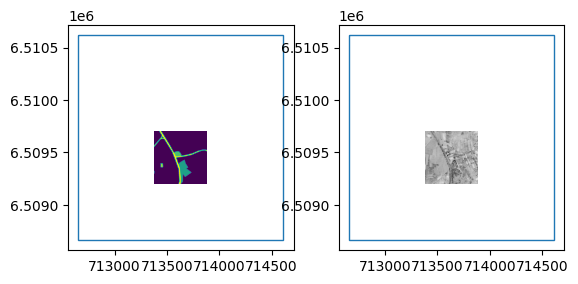

In [8]:
zone = np.random.choice(intersections)
mask46 = shapely.geometry.MultiPolygon(mask46polys)
ds = PolyRaster(
    raster_img_path=img_path_46,
    raster_label_path=label_path_46,
    polygon=zone,
    crop_size=512,
    labels='base',
    raster_mask_poly=mask46
)

item = ds[0]
print(item['image'][0].shape)

fig2, (ax2, ax3) = plt.subplots(1, 2)
f, e = shape_color("C0", 0)
zone_patch = plotting.patch_from_polygon(zone, facecolor=f, edgecolor=e)
ax2.add_patch(copy(zone_patch))
ax3.add_patch(copy(zone_patch))
rioplt.show(item['label'].numpy(), ax=ax2, transform=item['tf_label'], cmap='viridis')
rioplt.show(item['image'][0].numpy(), ax=ax3, transform=item['tf_image'], cmap='gray')
ax2.autoscale_view()
ax3.autoscale_view()

In [22]:
from torch.utils.data import DataLoader, RandomSampler, ConcatDataset
from dl_toolbox.torch_collate import CustomCollate

mask46 = shapely.geometry.MultiPolygon(mask46polys)
train_sets, test_sets = [], []
for i, zone in enumerate(intersections):
    dataset = PolyRaster(
        raster_img_path=img_path_46,
        raster_label_path=label_path_46,
        polygon=zone,
        crop_size=256,
        labels='base',
        raster_mask_poly=mask46
    )
    if i%5==0:
        test_sets.append(dataset)
    else:
        train_sets.append(dataset)
        
train_set = ConcatDataset(train_sets)
test_set = ConcatDataset(test_sets)

train_dataloader = DataLoader(
    dataset=train_set,
    batch_size=8,
    collate_fn=CustomCollate(),
    sampler=RandomSampler(
        data_source=train_set,
        replacement=True,
        num_samples=2000
    ),
    num_workers=6,
    pin_memory=True,
    drop_last=True
)

val_dataloader = DataLoader(
    dataset=test_set,
    sampler=RandomSampler(
        data_source=test_set,
        replacement=True,
        num_samples=500
    ),
    collate_fn=CustomCollate(),
    batch_size=8,
    num_workers=6,
    pin_memory=True
)

In [23]:
class LabelsToRGB:
    # Inputs shape : B,H,W or H,W
    # Outputs shape : B,H,W,3 or H,W,3

    def __init__(self, labels):

        self.labels = labels

    def __call__(self, labels):
        rgb = np.zeros(shape=(*labels.shape, 3), dtype=np.uint8)
        for label, key in enumerate(self.labels):
            mask = np.array(labels == label)
            rgb[mask] = np.array(self.labels[key]['color'])

        return rgb

labels_to_rgb = LabelsToRGB(labels_dict['base'])

for i, batch in enumerate(train_dataloader):
    print(batch.keys())
    for j in range(4):
        f, ax = plt.subplots(ncols=2, figsize=(20,12))
        imgs = batch['image']
        ax[0].imshow(batch['image'][j][0].numpy(), cmap='gray')
        ax[1].imshow(labels_to_rgb(batch['label'][j]))
        #ax[0].set_title(batch['path'][j])
        for l in range(2):
            ax[l].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    plt.show()  
    break


dict_keys(['image', 'label', 'crop', 'path'])


/tmp/ipykernel_7931/405870891.py:29: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


In [24]:
from dl_toolbox.lightning_modules import CE

module = CE(
    out_channels=9,
    ignore_zero=False,
    network='SmpUnet',
    encoder='efficientnet-b0',
    pretrained=False,
    weights=[],
    in_channels=1,
    initial_lr=0.001,
    final_lr=0.0005,
    plot_calib=False,
    ttas = ['vflip'],
    class_names=list(test_set.datasets[0].labels.keys()),
)

In [ ]:
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint#, DeviceStatsMonitor
from datetime import datetime

trainer = Trainer(
    max_steps=50000,
    accelerator='gpu',
    devices=1,
    limit_train_batches=1.,
    limit_val_batches=1.,
    logger=TensorBoardLogger(
        save_dir='/data/outputs/alumhi',
        name='test_alumhi',
        version=f'{datetime.now():%d%b%y-%Hh%Mm%S}'
    ),
    callbacks=[
        ModelCheckpoint(),
    ]
)
    
#ckpt_path='/data/outputs/test_bce_resisc/version_2/checkpoints/epoch=49-step=14049.ckpt'
trainer.fit(
    model=module,
    train_dataloaders={'sup': train_dataloader},
    val_dataloaders=val_dataloader,
    ckpt_path=None
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params
---------------------------------------------
0 | network | SmpUnet          | 6.3 M 
1 | loss    | CrossEntropyLoss | 0     
---------------------------------------------
6.3 M     Trainable params
0         Non-trainable params
6.3 M     Total params
25.008    Total estimated model params size (MB)


Epoch 0:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 250/313 [00:21<00:05, 11.37it/s, loss=0.56, v_num=5m05]
Validation: 0it [00:00, ?it/s]
Epoch 1:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 250/313 [00:22<00:05, 11.34it/s, loss=0.66, v_num=5m05]
Validation: 0it [00:00, ?it/s]
Epoch 2:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 250/313 [00:22<00:05, 11.33it/s, loss=0.617, v_num=5m05]
Validation: 0it [00:00, ?it/s]
Epoch 3:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 250/313 [00:22<00:05, 11.35it/s, loss=0.502, v_num=5m05]
Validation: 0it [00:00, ?it/s]
Epoch 4:  80%|██████████████████████████████████████